In this notebook we connect the hyperexcitable ridge of CA3 PCs with an inhibitory population. Our goal is explore how the connections between the PCs and INHs control the speed and activity level of the ridge propagation.

In [1]:
%reset -f
%matplotlib inline
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import os

import aux
from ntwk import LIFNtwk, cxns_pcs_rcr, ridge_h, sample_vs_gs_init
from plot import raster, set_font_size

import PARAMETERS as P

cc = np.concatenate

## top level save directory
SAVE_DIR = 'sims/balance'

## excitation-only simulations
EXC_DIR = os.path.join(SAVE_DIR, 'exc')

EXC_PATH_TIME = os.path.join(EXC_DIR, 'time.npy')
EXC_PRFX_NTWK = os.path.join(EXC_DIR, 'ntwk')

# EC->PC weight dstr vs dst to rat pos
EXC_PATH_W_N_PC_EC_VS_DIST = os.path.join(EXC_DIR, 'w_n_pc_ec_vs_dist.npy')

# initial Vm and G_N dstrs for diff EC rates
EXC_PRFX_V_0_G_0_VS_EC_RT = os.path.join(EXC_DIR, 'v_0_g_0/ec_rt')

## full-only simulations
FULL_DIR = os.path.join(SAVE_DIR, 'full')

FULL_PATH_TIME = os.path.join(FULL_DIR, 'time.npy')
FULL_PRFX_NTWK = os.path.join(FULL_DIR, 'ntwk')

# INH population response to stochastic inputs

We now explore the potential that a pool of inhibitory neurons might have to bring the activity propagation into a precisely controllable regime.

### Dependence of INH response to PC inputs on distribution of PC-->INH cxn strengths

For several different PC-->INH cxn strengths, we measure the population response to different PC spking rates.

In [2]:
# POPULATION GEOMETRY AND STATS
RIDGE_SHAPE = (6, 0.25)  # m
PC_DENS = 1000  # per m^2
P_INH = 0.1

# PC->INH CONNECTIVITY
P_A_INH_PC = 0.1
WS_A_INH_PC = [
    0.002, 0.003, 0.004, 0.005, 0.007,
    0.009, 0.011, 0.013, 0.015, 0.017, 0.019
]

# PC ACTIVATION
PC_SPK_RATES = [3, 7, 11, 15, 19, 23, 27]
PC_SPK_RATE_DUR = 0.25
DUR = PC_SPK_RATE_DUR * len(PC_SPK_RATES)

# make ridge
hx = aux.load(EXC_PATH_W_N_PC_EC_VS_DIST)
pfcs, ws_n_pc_ec = ridge_h(RIDGE_SHAPE, PC_DENS, hx)

# get inh population
N_PC = pfcs.shape[1]
N_INH = np.random.poisson(N_PC/(1/P_INH - 1))

print('N_PC = {}'.format(N_PC))
print('N_INH = {}'.format(N_INH))

# intrinsic cell properties
ntwk_kwargs = {
    # intrinsic cell properties
    't_m': P.T_M_INH,
    'e_l': P.E_L_INH,
    'v_th': P.V_TH_INH,
    'v_reset': P.V_RESET_INH,
    't_r': P.T_R,
    # synaptic properties
    'es_syn': {'AMPA': P.E_A},
    'ts_syn': {'AMPA': P.T_A},
    # connectivity
    'ws_rcr': {'AMPA': np.zeros((N_INH, N_INH))},
}

# time vector and spks_up
t = np.arange(0, DUR, P.DT)
spks_up = np.zeros((len(t), N_PC))

for ctr, rate in enumerate(PC_SPK_RATES):
    
    start = ctr*PC_SPK_RATE_DUR
    end = (ctr+1)*PC_SPK_RATE_DUR
    mask = (start <= t) & (t < end)
    
    spks_up[mask, :] = np.random.binomial(1, rate*P.DT, (mask.sum(), N_PC))

N_PC = 1481
N_INH = 171


In [3]:
# run ntwk sim for each PC->INH cxn weight
rsps = []
vs_init = P.E_L_INH * np.ones(N_INH)
cx_up_a = np.random.binomial(1, P_A_INH_PC, (N_INH, N_PC))

for w_a_inh_pc in WS_A_INH_PC:
    
    # build ntwk
    ntwk_kwargs_ = deepcopy(ntwk_kwargs)
    ntwk_kwargs_['ws_up'] = {'AMPA': w_a_inh_pc * cx_up_a}

    ntwk = LIFNtwk(**ntwk_kwargs_)

    # run ntwk and save response
    rsp = ntwk.run(spks_up=spks_up, dt=P.DT, vs_init=vs_init)
    rsps.append(rsp)

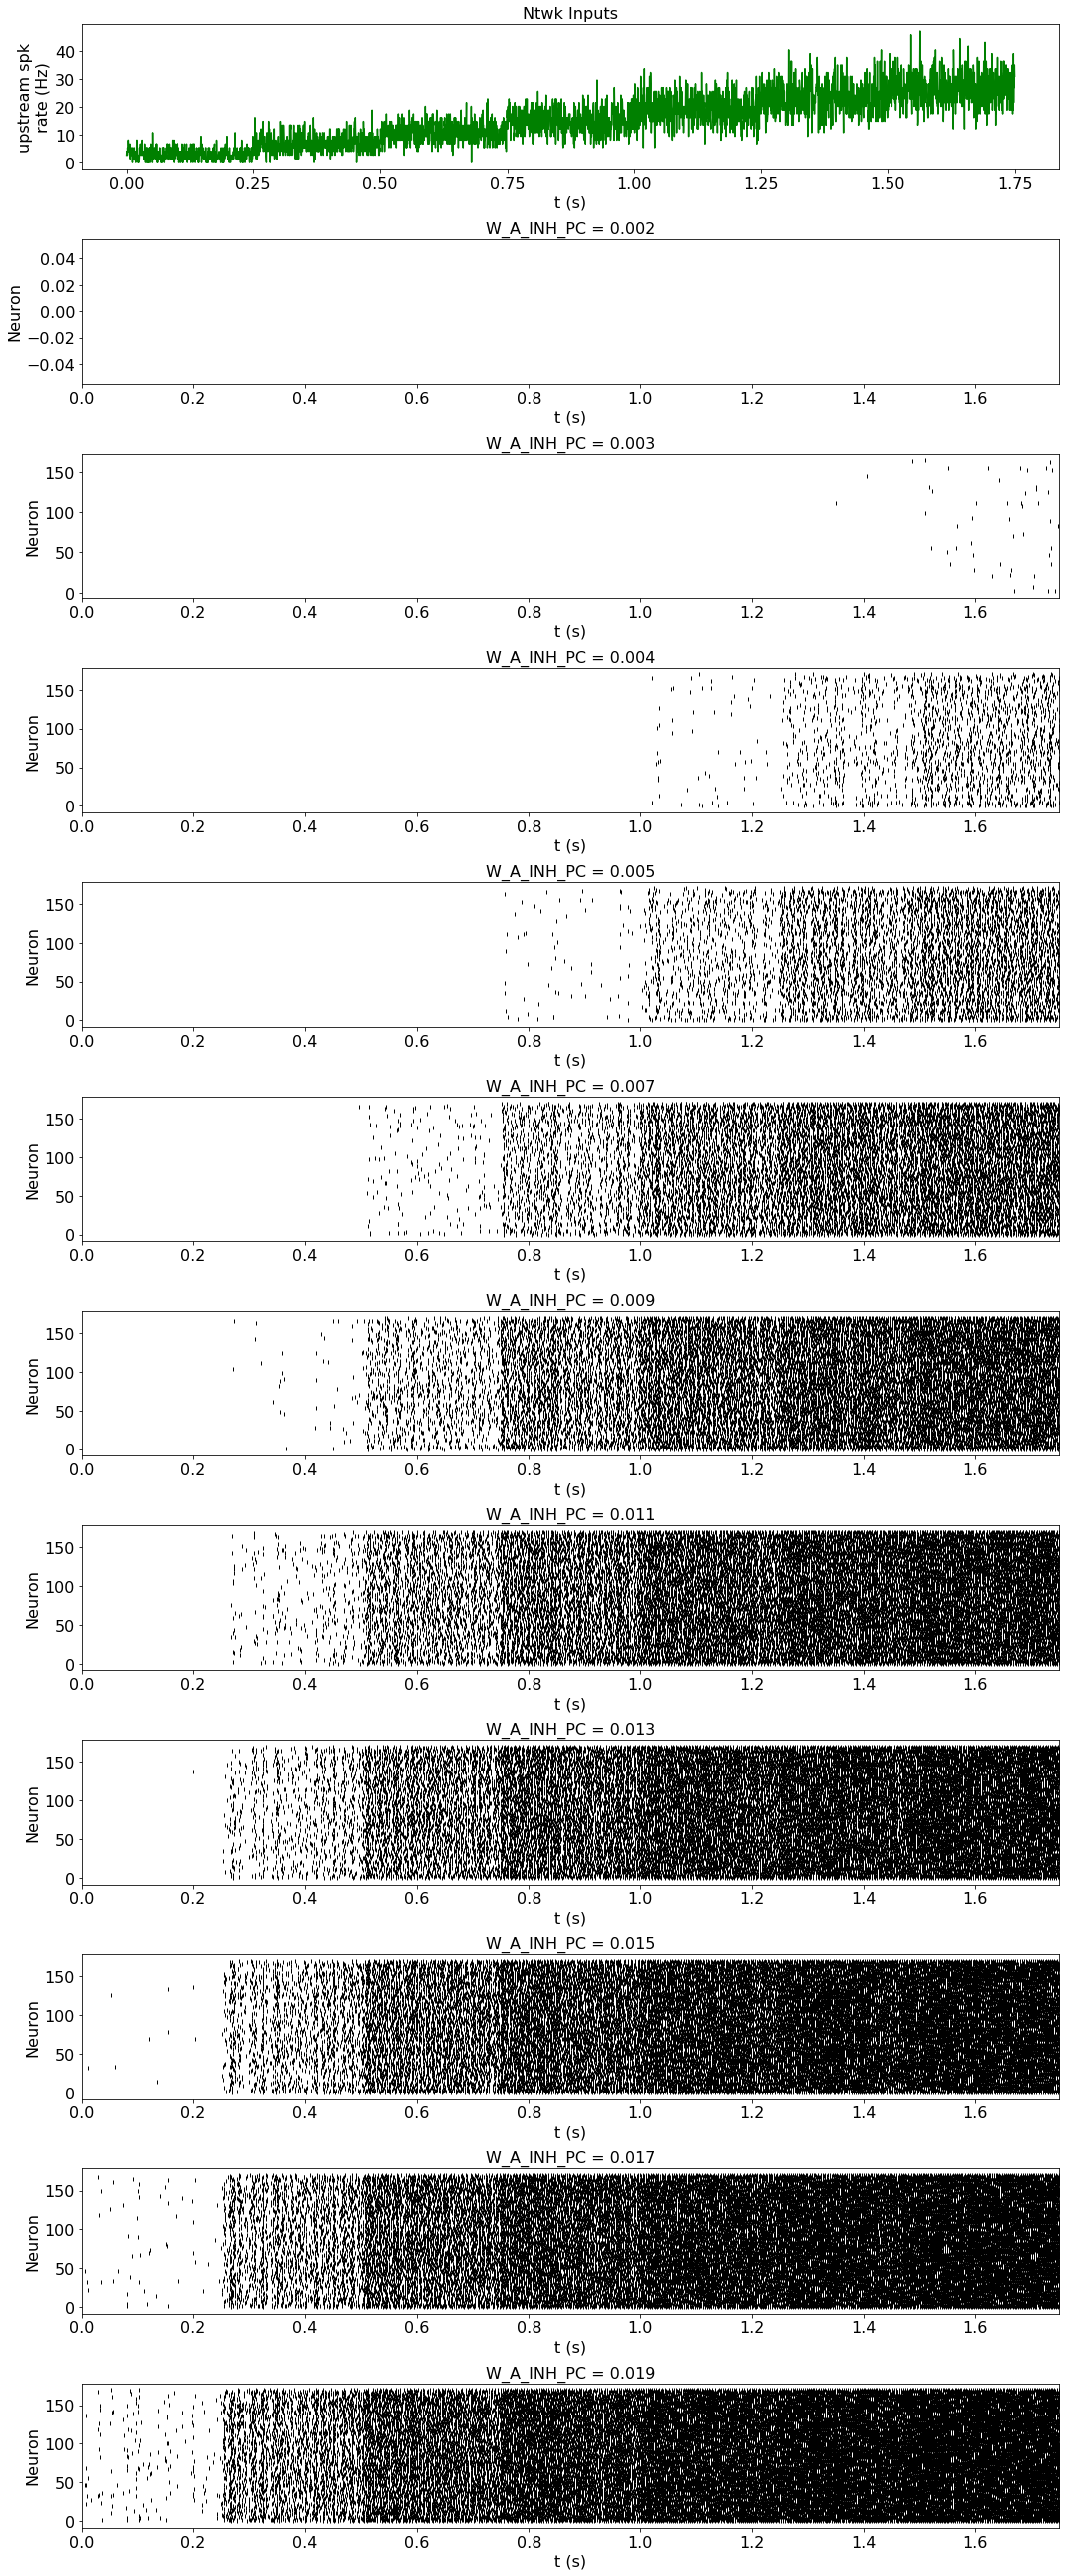

In [4]:
# plot rasters
n_axs = len(rsps) + 1
fig_size = (15, 3 * n_axs)
fig, axs = plt.subplots(n_axs, 1, figsize=fig_size, tight_layout=True, squeeze=False)
axs = axs[:, 0]

axs[0].plot(t, spks_up.sum(1)/P.DT/N_PC, color='g')

axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('upstream spk\nrate (Hz)')
axs[0].set_title('Ntwk Inputs')

for w_a_inh_pc, rsp, ax in zip(WS_A_INH_PC, rsps, axs[1:]):
    
    raster(ax, t, rsp.spks, lw=1, zorder=1)
    ax.set_title('W_A_INH_PC = {}'.format(w_a_inh_pc))
    
for ax in axs:
    set_font_size(ax, 16)

This shows how setting the PC->INH cxn weight effectively changes the minimum input required for the INH ntwk to respond.

# INH response to HX PC ridge activity propagation

Instead of driving the INH population with Bernoulli PC spikes, we now drive it with spikes generated from activity propagating along the HX PC ridge. However, we do not connect the INH population back to the PCs yet. Our goal is to demonstrate, for a few PC ridges (varying in their local connectivity statistics), how the INH response depends on the PC->INH connectivity.

In [5]:
# POPULATION GEOMETRY AND STATS
RIDGE_SHAPE = (6, 0.25)
PC_DENS = 1000
P_INH = 0.1

# PC-PC CX PARAMS
Z_PC = 0.8
L_PC = 0.2

# PC->INH CX PARAMS
P_A_INH_PC = 0.1
WS_A_INH_PC = [.003, .004, .005, .009, .013, .017, .019]

# AFTERHYPERPOLARIZATION
W_AHP = 1

# INPUTS
STIM = (0.01, 0.012)
N_STIM = 50
RATE_PL = 5000
RATE_EC = 35

# SIMULATION
DUR = 0.08

# make ridge with place fields
hx = aux.load(EXC_PATH_W_N_PC_EC_VS_DIST)
pfcs, ws_n_pc_ec = ridge_h(RIDGE_SHAPE, PC_DENS, hx)

# get inh population size
N_PC = pfcs.shape[1]
N_INH = np.random.poisson(N_PC/(1/P_INH - 1))
N = N_PC + N_INH

# sort nrns by distance to x-coord as well as 
# left-most point on ridge, which is
# the order they'll be recruited into the initial stim
x_order = np.argsort(pfcs[0])
stim_order = np.argsort(
    np.sqrt((pfcs[0] + (RIDGE_SHAPE[0]/2))**2 + pfcs[1]**2))

# make upstream connectivity matrix (N, 2*N_PC)
ws_up_a = P.W_A_PC_PL * np.eye(N_PC)
ws_up_n = np.diag(ws_n_pc_ec)
ws_up = {}

# ampa inputs from PL
w_up_a = np.zeros((N, 2*N_PC))
w_up_a[:N_PC, :] = cc([ws_up_a, np.zeros((N_PC, N_PC))], axis=1)

# nmda inputs from EC
w_up_n = np.zeros((N, 2*N_PC))
w_up_n[:N_PC, :] = cc([np.zeros((N_PC, N_PC)), ws_up_n], axis=1)

# make recurrent connectivity
w_rcr_a = np.zeros((N, N))
w_rcr_n = np.zeros((N, N))

# local PC->PC exc cxs
# (PC->INH cxs will be added inside loop)
w_rcr_a[:N_PC, :N_PC] = P.W_A_PC_PC*cxns_pcs_rcr(pfcs, Z_PC, L_PC)

# fixed ntwk params
t_m = cc([np.repeat(P.T_M_PC, N_PC), np.repeat(P.T_M_INH, N_INH)])
e_l = cc([np.repeat(P.E_L_PC, N_PC), np.repeat(P.E_L_INH, N_INH)])
v_th = cc([np.repeat(P.V_TH_PC, N_PC), np.repeat(P.V_TH_INH, N_INH)])
v_reset = cc([np.repeat(P.V_RESET_PC, N_PC), np.repeat(P.V_RESET_INH, N_INH)])

w_ahp = cc([np.repeat(W_AHP, N_PC), np.repeat(0, N_INH)])

ntwk_kwargs = {
    # intrinsic cell properties
    't_m': t_m,
    'e_l': e_l,
    'v_th': v_th,
    'v_reset': v_reset,
    't_r': P.T_R,
    'e_ahp': P.E_AHP,
    't_ahp': 0.05,
    'w_ahp': w_ahp,
    
    # synaptic properties
    'es_syn': {'AMPA': P.E_A, 'NMDA': P.E_N},
    'ts_syn': {'AMPA': P.T_A, 'NMDA': P.T_N},
    
    # connectivity
    'ws_up': {'AMPA': w_up_a, 'NMDA': w_up_n},
}

# upstream spk inputs
t = np.arange(0, DUR, P.DT)
spks_up = np.zeros((len(t), 2*N_PC))

# place-tuned inputs
mask_pl = (STIM[0] <= t) & (t < STIM[1])
spks_up_pl = np.zeros((mask_pl.sum(), 2*N_PC))
spks_up_pl[:, stim_order[:N_STIM]] \
    = np.random.poisson(RATE_PL*P.DT, (mask_pl.sum(), N_STIM))
spks_up[mask_pl, :] = spks_up_pl

# EC inputs
spks_up[:, N_PC:] = np.random.poisson(RATE_EC*P.DT, (len(t), N_PC))

In [6]:
# set initial voltages and conductances
v_g_init = aux.load('{}_{}Hz.npy'.format(EXC_PRFX_V_0_G_0_VS_EC_RT, RATE_EC))

vs_init_pc, gs_init_pc = sample_vs_gs_init(ws_n_pc_ec, v_g_init)
vs_init = cc([vs_init_pc, np.repeat(P.E_L_INH, N_INH)])

gs_init = {'AMPA': np.zeros(N)}
gs_init['NMDA'] = cc([gs_init_pc['NMDA'], np.zeros(N_INH)])

cx_a_inh_pc = np.random.binomial(1, P_A_INH_PC, (N_INH, N_PC))

# loop over PC->INH cxn weights
rsps = []

for w_a_inh_pc in WS_A_INH_PC:
    
    # make PC->INH cxs
    w_rcr_a_inh_pc = w_a_inh_pc * cx_a_inh_pc
    w_rcr_a_ = deepcopy(w_rcr_a)
    w_rcr_a_[-N_INH:, :N_PC] = w_rcr_a_inh_pc
    
    # make ntwk
    ntwk_kwargs_ = deepcopy(ntwk_kwargs)
    ntwk_kwargs_['ws_rcr'] = {'AMPA': w_rcr_a_, 'NMDA': w_rcr_n}
    
    ntwk = LIFNtwk(**ntwk_kwargs_)

    # run ntwk and save response
    rsp = ntwk.run(spks_up=spks_up, dt=P.DT, vs_init=vs_init)
    
    rsps.append(rsp)

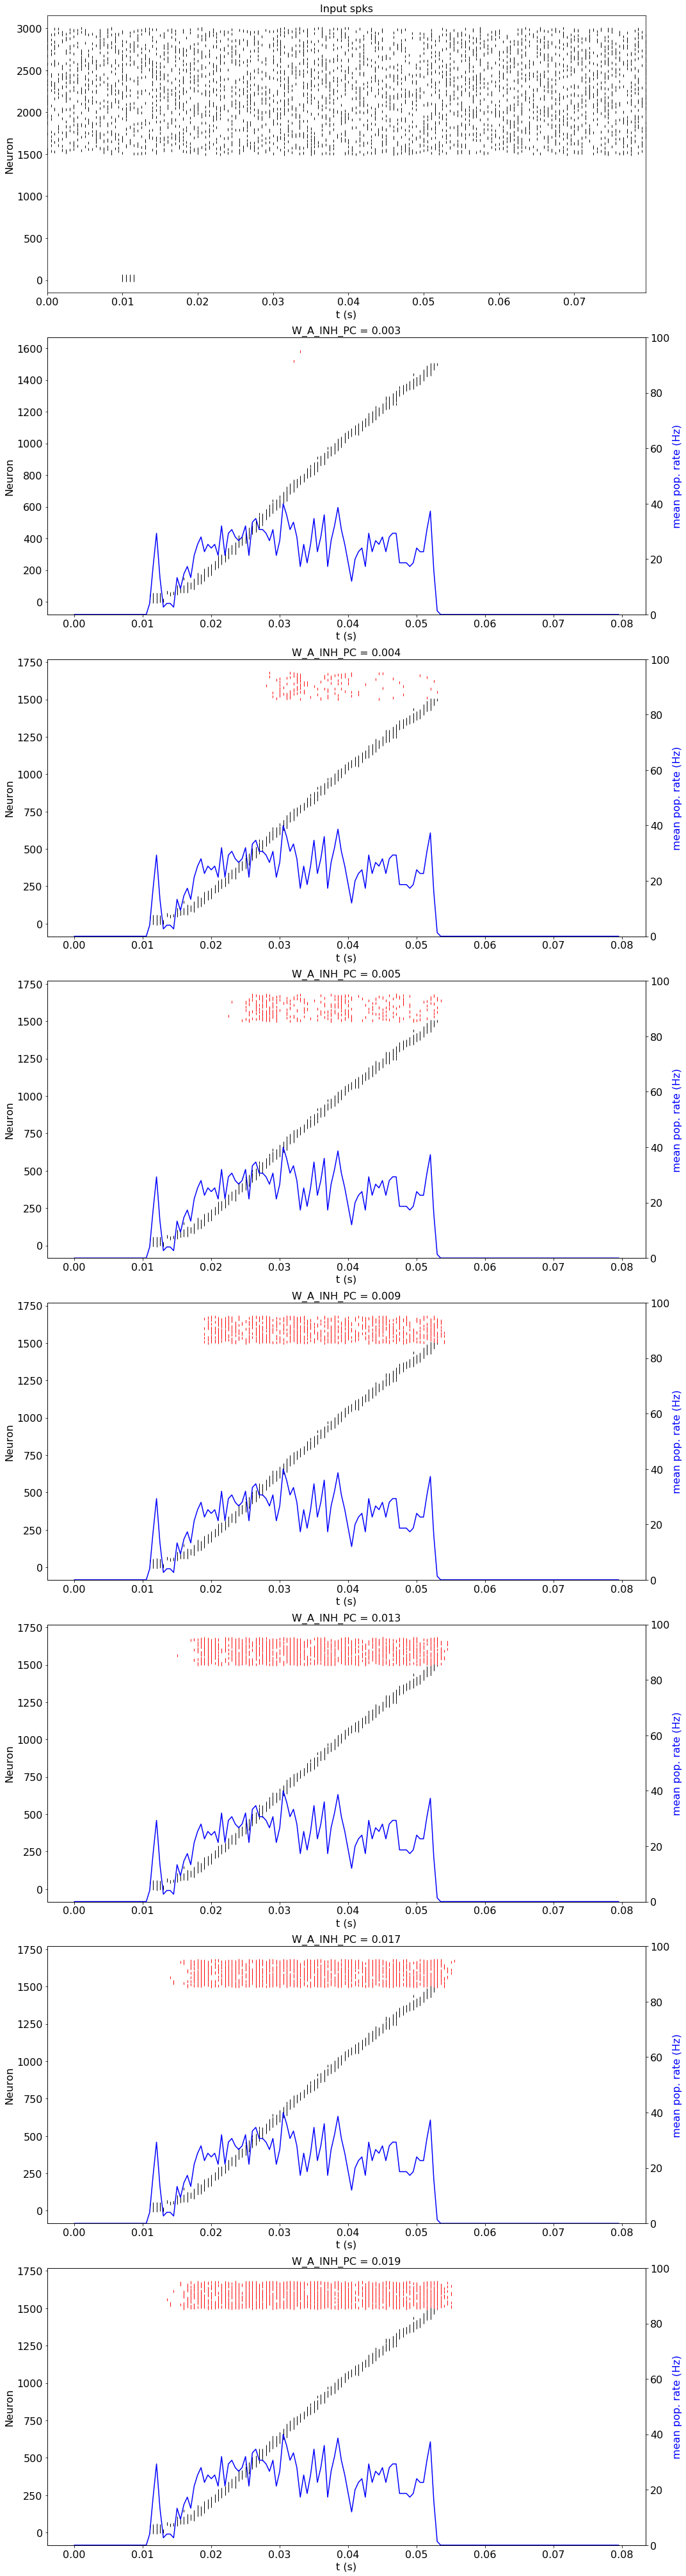

In [7]:
# make plots
n_axs = 1+len(WS_A_INH_PC)
fig_size = (15, 7*n_axs)
fig, axs = plt.subplots(n_axs, 1, figsize=fig_size, tight_layout=True, squeeze=False)
axs = axs[:, 0]

order_up = cc([x_order, x_order+N_PC])

raster(axs[0], t, spks_up, order=order_up, lw=1, c='k')
axs[0].set_title('Input spks')

order_rcr = cc([x_order, np.arange(N_PC, N)])

for ax, w_a_inh_pc, rsp in zip(axs[1:], WS_A_INH_PC, rsps):
    
    # plot exc spikes
    spks_pc = rsp.spks.copy()
    spks_pc[:, -N_INH:] = 0
    
    raster(ax, t, spks_pc, order=order_rcr, lw=1, c='k')
    
    # plot inh spikes
    spks_inh = rsp.spks.copy()
    spks_inh[:, :N_PC] = 0
    
    raster(ax, t, spks_inh, lw=1, c='r')
    
    ax.set_title('W_A_INH_PC = {}'.format(w_a_inh_pc))
    
    ax_twin = ax.twinx()
    ax_twin.plot(t, spks_pc[:, :N_PC].mean(1)/P.DT, color='b', lw=1.5)
    ax_twin.set_ylim(0, 100)
    ax_twin.set_ylabel('mean pop. rate (Hz)', color='b')
    
    set_font_size(ax_twin, 16)
    
for ax in axs:
    set_font_size(ax, 16)

# Full HX Ridge Simulation

We now combine the excitation-only ridge simulation with an inhibitory population in our attempt to control the "operating" point of the network, that is, the average activation during propagation.

In [8]:
# POPULATION GEOMETRY AND STATS
RIDGE_SHAPE = (6, 0.25)
PC_DENS = 1000
P_INH = 0.1

# PC-PC CXN PARAMS
Z_PC = 0.8
L_PC = 0.2

# PC->INH CXN PARAMS
P_A_INH_PC = 0.1
W_A_INH_PC = .009

# INH->PC CXN
P_G_PC_INH = 0.1
WS_G_PC_INH = np.arange(0, .009, .001)

# AFTERHYPERPOLARIZATION
W_AHP = 1

# INPUTS
STIM = (0.01, 0.012)
N_STIM = 50
RATE_PL = 5000
RATE_EC = 35

# SIMULATION
SEED = 0
DUR = 0.1

np.random.seed(SEED)

# make ridge with place fields
hx = aux.load(EXC_PATH_W_N_PC_EC_VS_DIST)
pfcs, ws_n_pc_ec = ridge_h(RIDGE_SHAPE, PC_DENS, hx)

# get inh population size
N_PC = pfcs.shape[1]
N_INH = np.random.poisson(N_PC/(1/P_INH - 1))
N = N_PC + N_INH

# sort nrns by distance to x-coord as well as 
# left-most point on ridge, which is
# the order they'll be recruited into the initial stim
x_order = np.argsort(pfcs[0])
stim_order = np.argsort(
    np.sqrt((pfcs[0] + (RIDGE_SHAPE[0]/2))**2 + pfcs[1]**2))

# make upstream connectivity matrix (N, 2*N_PC)
ws_up_a = P.W_A_PC_PL * np.eye(N_PC)
ws_up_n = np.diag(ws_n_pc_ec)
ws_up = {}

# ampa inputs from PL
w_up_a = np.zeros((N, 2*N_PC))
w_up_a[:N_PC, :] = cc([ws_up_a, np.zeros((N_PC, N_PC))], axis=1)

# nmda inputs from EC
w_up_n = np.zeros((N, 2*N_PC))
w_up_n[:N_PC, :] = cc([np.zeros((N_PC, N_PC)), ws_up_n], axis=1)

# gaba inputs
w_up_g = np.zeros((N, 2*N_PC))

# make recurrent connectivity
w_rcr_a = np.zeros((N, N))
w_rcr_n = np.zeros((N, N))

# local PC->PC cxns
w_rcr_a[:N_PC, :N_PC] = P.W_A_PC_PC*cxns_pcs_rcr(pfcs, Z_PC, L_PC)
# PC->INH cxns
w_rcr_a[-N_INH:, :N_PC] = W_A_INH_PC*np.random.binomial(1, P_A_INH_PC, (N_INH, N_PC))

# fixed ntwk params
t_m = cc([np.repeat(P.T_M_PC, N_PC), np.repeat(P.T_M_INH, N_INH)])
e_l = cc([np.repeat(P.E_L_PC, N_PC), np.repeat(P.E_L_INH, N_INH)])
v_th = cc([np.repeat(P.V_TH_PC, N_PC), np.repeat(P.V_TH_INH, N_INH)])
v_reset = cc([np.repeat(P.V_RESET_PC, N_PC), np.repeat(P.V_RESET_INH, N_INH)])

w_ahp = cc([np.repeat(W_AHP, N_PC), np.repeat(0, N_INH)])

ntwk_kwargs = {
    # intrinsic cell properties
    't_m': t_m,
    'e_l': e_l,
    'v_th': v_th,
    'v_reset': v_reset,
    't_r': P.T_R,
    'e_ahp': P.E_AHP,
    't_ahp': 0.05,
    'w_ahp': w_ahp,
    
    # synaptic properties
    'es_syn': {'AMPA': P.E_A, 'NMDA': P.E_N, 'GABA': P.E_G},
    'ts_syn': {'AMPA': P.T_A, 'NMDA': P.T_N, 'GABA': P.T_G},
    
    # connectivity
    'ws_up': {'AMPA': w_up_a, 'NMDA': w_up_n, 'GABA': w_up_g},
}

# upstream spk inputs
t = np.arange(0, DUR, P.DT)
spks_up = np.zeros((len(t), 2*N_PC))

# place-tuned inputs
mask_pl = (STIM[0] <= t) & (t < STIM[1])
spks_up_pl = np.zeros((mask_pl.sum(), 2*N_PC))
spks_up_pl[:, stim_order[:N_STIM]] \
    = np.random.poisson(RATE_PL*P.DT, (mask_pl.sum(), N_STIM))
spks_up[mask_pl, :] = spks_up_pl

# EC inputs
spks_up[:, N_PC:] = np.random.poisson(RATE_EC*P.DT, (len(t), N_PC))

In [9]:
# set initial voltages and conductances
v_g_init = aux.load('{}_{}Hz.npy'.format(EXC_PRFX_V_0_G_0_VS_EC_RT, RATE_EC))

vs_init_pc, gs_init_pc = sample_vs_gs_init(ws_n_pc_ec, v_g_init)
vs_init = cc([vs_init_pc, np.repeat(P.E_L_INH, N_INH)])

gs_init = {'AMPA': np.zeros(N), 'GABA': np.zeros(N)}
gs_init['NMDA'] = cc([gs_init_pc['NMDA'], np.zeros(N_INH)])

cxn_g_pc_inh = np.random.binomial(1, P_G_PC_INH, (N_PC, N_INH))

# loop over PC->INH cxn weights
rsps = []

for w_g_pc_inh in WS_G_PC_INH:
    
    # make INH->PC cxs
    w_rcr_g = np.zeros((N, N))
    w_rcr_g_pc_inh = w_g_pc_inh * cxn_g_pc_inh
    w_rcr_g[:N_PC, -N_INH:] = w_rcr_g_pc_inh
    
    # make ntwk
    ntwk_kwargs_ = deepcopy(ntwk_kwargs)
    ntwk_kwargs_['ws_rcr'] = {'AMPA': w_rcr_a, 'NMDA': w_rcr_n, 'GABA': w_rcr_g}
    
    ntwk = LIFNtwk(**ntwk_kwargs_)

    # run ntwk and save response
    rsp = ntwk.run(spks_up=spks_up, dt=P.DT, vs_init=vs_init)
    
    rsps.append(rsp)

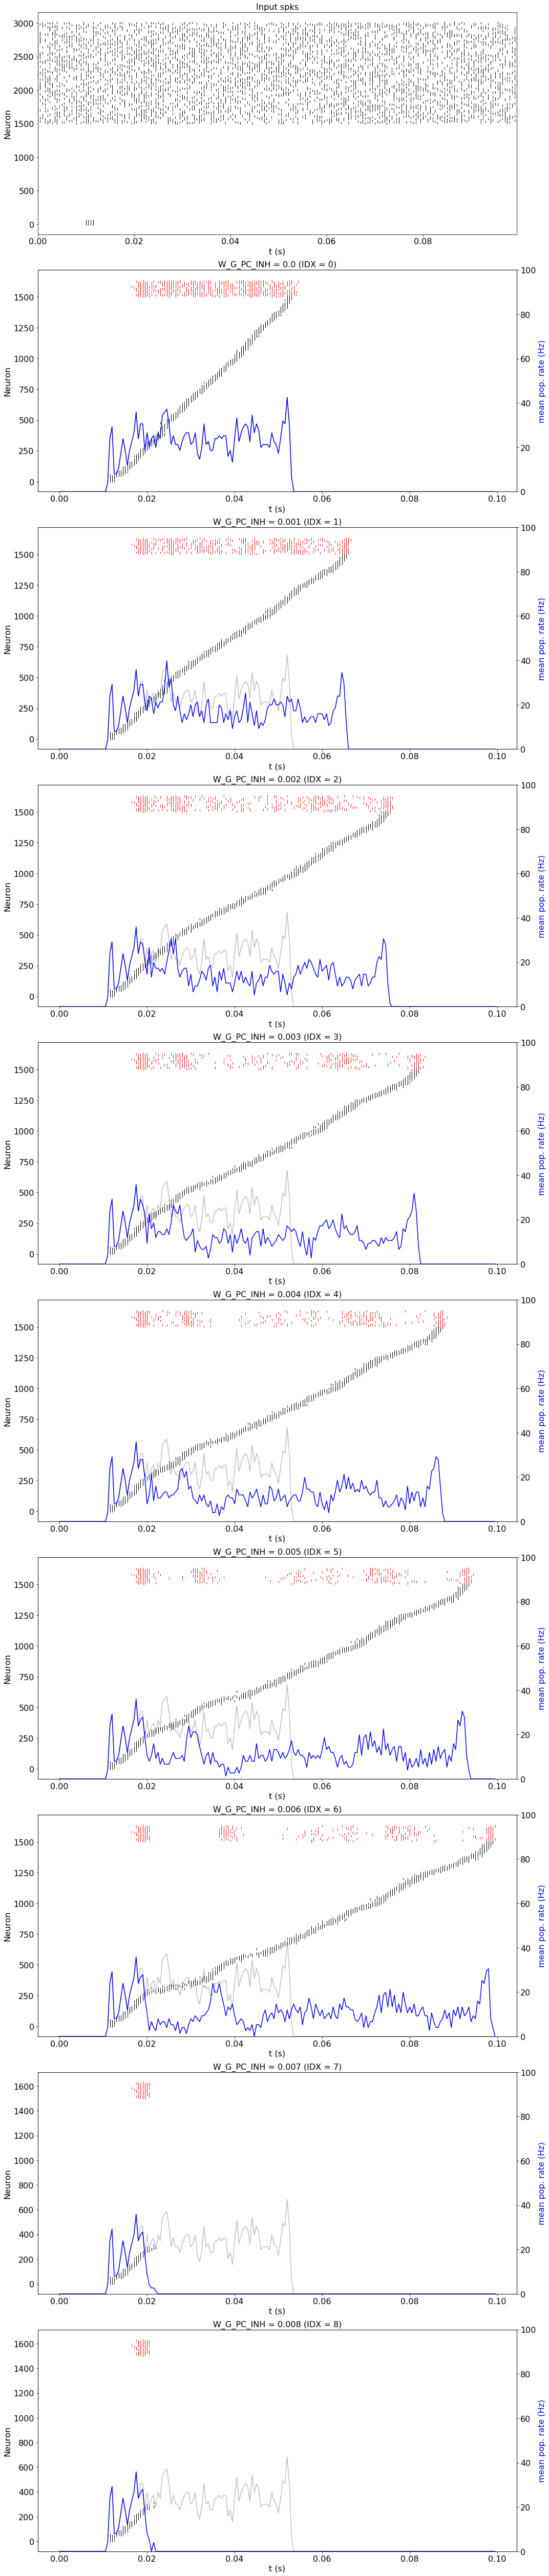

In [10]:
# make plots
n_axs = 1+len(WS_G_PC_INH)
fig_size = (15, 7*n_axs)
fig, axs = plt.subplots(n_axs, 1, figsize=fig_size, tight_layout=True, squeeze=False)
axs = axs[:, 0]

order_up = cc([x_order, x_order+N_PC])

raster(axs[0], t, spks_up, order=order_up, lw=1, c='k')
axs[0].set_title('Input spks')

order_rcr = cc([x_order, np.arange(N_PC, N)])

for ctr, (ax, w_g_inh_pc, rsp) in enumerate(zip(axs[1:], WS_G_PC_INH, rsps)):
    
    # plot exc spikes
    spks_pc = rsp.spks.copy()
    spks_pc[:, -N_INH:] = 0
    
    raster(ax, t, spks_pc, order=order_rcr, lw=1, c='k')
    
    # plot inh spikes
    spks_inh = rsp.spks.copy()
    spks_inh[:, :N_PC] = 0
    
    raster(ax, t, spks_inh, lw=1, c='r')
    
    ax.set_title('W_G_PC_INH = {} (IDX = {})'.format(w_g_inh_pc, ctr))
    
    ax_twin = ax.twinx()
    ax_twin.plot(t, rsps[0].spks[:, :N_PC].mean(1)/P.DT, color='gray', alpha=.5)
    ax_twin.plot(t, spks_pc[:, :N_PC].mean(1)/P.DT, color='b', lw=1.5)
    ax_twin.set_ylim(0, 100)
    ax_twin.set_ylabel('mean pop. rate (Hz)', color='b')
    
    set_font_size(ax_twin, 16)
    
for ax in axs:
    set_font_size(ax, 16)

### Save and animate example simulations

In [11]:
XMP_IDXS = [0, 6]

aux.save_time_file(FULL_PATH_TIME, t)

xmp_ntwk_paths = []

for xmp_idx in XMP_IDXS:
    
    rsp = deepcopy(rsps[xmp_idx])
    rsp.place_field_centers = pfcs
    
    xmp_ntwk_path = '{}_w_g_pc_inh_{}.npy'.format(FULL_PRFX_NTWK, WS_G_PC_INH[xmp_idx])
    xmp_ntwk_paths.append(rsp.save(xmp_ntwk_path))

In [12]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
from anim import build_frames

frames = []

for xmp_idx, xmp_ntwk_path in zip(XMP_IDXS, xmp_ntwk_paths):
    
    save_prefix = os.path.join(
        FULL_DIR, 'ntwk', 'w_g_pc_inh_{}.npy'.format(WS_G_PC_INH[xmp_idx]))
    
    positions_pc = pfcs
    positions_inh = np.random.normal([0, -.4], [1, .05], (N_INH, 2)).T
    
    positions = cc([positions_pc, positions_inh], axis=1)
    
    frames.append(build_frames.ntwk_activity(
        save_prefix=save_prefix,
        time_file=FULL_PATH_TIME,
        ntwk_file=xmp_ntwk_path,
        fps=1000,
        box=[-3.1, 3.1, -.6, .2],
        resting_size=30,
        spk_size=400,
        amp=3,
        positions=positions,
        default_color='k',
        cxn_color='k',
        cxn_lw=.05,
        frames_per_spk=2,
        title='Network Activity',
        x_label='x (m)',
        y_label='y (m)',
        fig_size=(15, 9),
        verbose=True))
    
    print('')

Using timestamp file "sims/balance/full/time.npy" and activity file "sims/balance/full/ntwk_w_g_pc_inh_0.0.npy".
Frames will be saved with prefix "sims/balance/full/ntwk/w_g_pc_inh_0.0.npy".
Loading timestamps and network activity data...
Downsampling data from 2000.0 Hz to 1000 fps...
Data downsampled.
Data loaded.
Generating and saving 100 frames...
6 frames completed after 32.051 s...
12 frames completed after 64.122 s...
18 frames completed after 96.289 s...
24 frames completed after 128.330 s...
30 frames completed after 160.355 s...
36 frames completed after 192.396 s...
42 frames completed after 224.510 s...
48 frames completed after 256.584 s...
54 frames completed after 288.683 s...
60 frames completed after 320.824 s...
66 frames completed after 352.910 s...
72 frames completed after 384.950 s...
78 frames completed after 417.041 s...
84 frames completed after 449.188 s...
90 frames completed after 481.250 s...
96 frames completed after 513.291 s...
All frames written to disk

In [13]:
from anim import create_mp4

for frames_, xmp_idx in zip(frames, XMP_IDXS):
    
    save_path = os.path.join(FULL_DIR, 'w_g_pc_inh_{}.npy'.format(WS_G_PC_INH[xmp_idx]))
    
    movie = create_mp4(
        frames_, save_path, playback_fps=30, verbose=True)

Loading source images...


Source images loaded.
Generating movie and saving at "sims/balance/full/w_g_pc_inh_0.0.npy.mp4"...
Movie generated.
Loading source images...


Source images loaded.
Generating movie and saving at "sims/balance/full/w_g_pc_inh_0.006.npy.mp4"...
Movie generated.


### PLOT

* (m x n) ax figure, one row per param set
* 1st col shows excitatory cxn probability curve and inhibitory distribution overlaid atop one another
* later cols show raster plots of activity for different trials